In [1]:
# LOAD Packages 
import uproot
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import os
import math
import csv
import seaborn as sns
import sympy as smp
import sympy.stats
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# open file
tracks = uproot.open("/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/track_reco_benchmark.root")
tracks["RecoBenchmarkTree"].show()
tracks["RecoBenchmarkTree"].keys()
tracks["RecoBenchmarkTree"][0].num_entries

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_length          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_rot       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_incl      | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_y         | std::

1

In [3]:
# Set up data frame
df = tracks["RecoBenchmarkTree"].arrays(library="pd")
df 

reco_energy   reco_p_x   reco_p_y   reco_p_z  reco_p_mag  \
entry subentry                                                             
0     0            0.187154  -0.234381   0.108632  -0.143295    0.295413   
      1          100.000000  -7.290873  11.665427  99.155899  100.105601   
      2            0.120359   0.033664   0.061496   0.187096    0.199800   
      3          100.000000 -91.388336  30.254826  27.581352  100.139470   
      4          100.000000  67.088242 -67.580360 -33.462147  100.933902   
...                     ...        ...        ...        ...         ...   
      24587        0.075248  -0.017770   0.159418   0.030610    0.163300   
      24588        0.031133   0.000000  -0.202775  -0.135183    0.243705   
      24589        0.038879  -0.227060   0.000000  -0.151373    0.272892   
      24590        0.109844   0.288212  -0.158249   0.331788    0.467111   
      24591        0.073931   0.006341  -0.020251  -0.160165    0.161564   

                reco_length  reco_angle  reco_angle_rot  reco_angle_incl  \
entry subentry                                                             
0     0           56.152719    2.096729        2.493984         0.646119   
      1            7.163349    0.192754        1.632734         3.017238   
      2           25.432769    0.446119        1.413237         2.780756   
      3           23.939495    1.308800        2.708240         2.293776   
      4           11.382519    1.887476        0.847011        -1.083897   
...                     ...         ...             ...              ...   
      24587       19.230481    1.419478        1.709584         1.781890   
      24588        0.991476    1.976150        1.570796        -1.107149   
      24589        1.470591    1.858166        2.701083        -0.785402   
      24590        9.173130    0.805899        0.827504        -2.736701   
      24591       17.000214    2.950702        1.544711        -0.130827   

                reco_angle_x  ...  true_track_start_z  true_track_end_x  \
entry subentry                ...                                         
0     0             2.493984  ...           -2.462001         34.102234   
      1             1.632734  ...           57.443600         -3.964816   
      2             1.413237  ...           26.405602        -30.465925   
      3             2.708240  ...           53.896400         41.147820   
      4             0.847011  ...           60.104000         33.963779   
...                      ...  ...                 ...               ...   
      24587         1.709584  ...           37.934002          6.818858   
      24588         1.570796  ...           37.934002          5.286268   
      24589         2.701083  ...           39.264202          5.701339   
      24590         0.827504  ...           39.264202         12.965200   
      24591         1.544711  ...           39.264202          6.068530   

                true_track_end_y  true_track_end_z  true_pdg  \
entry subentry                                                 
0     0                37.245602        -20.198002      -211   
      1               -30.151199         64.094604       -13   
      2               -61.632603          3.792201        13   
      3               -52.764603         60.990803       211   
      4               -45.670200         64.538002      -211   
...                          ...               ...       ...   
      24587           -61.632603         33.943394      2212   
      24588           -44.783401         37.490601      2212   
      24589           -42.566402         38.820793      2212   
      24590           -45.226803         45.915199      2212   
      24591           -42.566402         39.707600       -13   

                true_ixn_charged_track_mult  true_ixn_index  spill_index  \
entry subentry                                                             
0     0                                   4             0.0            1   
 

In [4]:
# DEFINE: Bins for length and angles
num_length_bins = 15
max_length = 150
length_bins = np.linspace(0.,max_length, num_length_bins)
beam_angle_bins = np.linspace(-2*np.pi, 2*np.pi, 72)
rot_angle_bins = np.linspace(-2*np.pi, 2*np.pi, 72)
incl_angle_bins = np.linspace(-2*np.pi, 2*np.pi, 72)

# GET: Bin numbers for length and angles
reco_length_bin_nums = np.digitize(df['reco_length'], length_bins)
reco_beam_angle_bin_nums = np.digitize(df['reco_angle'], beam_angle_bins)
reco_rot_angle_bin_nums = np.digitize(df['reco_angle_rot'], rot_angle_bins)
reco_incl_angle_bin_nums = np.digitize(df['reco_angle_incl'], incl_angle_bins)

true_length_bin_nums = np.digitize(df['true_length'], length_bins)
true_beam_angle_bin_nums = np.digitize(df['true_angle'], beam_angle_bins)
true_rot_angle_bin_nums = np.digitize(df['true_angle_rot'], rot_angle_bins)
reco_incl_angle_bin_nums = np.digitize(df['reco_angle_incl'], incl_angle_bins)

# POPULATE: Add Bin numbers columns to df:
df['reco_length_bin'] = reco_length_bin_nums
df['reco_beam_angle_bin'] = reco_beam_angle_bin_nums
df['reco_angle_rot_bin'] = reco_rot_angle_bin_nums
df['reco_angle_incl_bin'] = reco_incl_angle_bin_nums

df['true_length_bin'] = true_length_bin_nums    
df['true_beam_angle_bin'] = true_beam_angle_bin_nums
df['true_angle_rot_bin'] = true_rot_angle_bin_nums
df['true_angle_incl_bin'] = reco_incl_angle_bin_nums

# CHECK: Progress
df

reco_energy   reco_p_x   reco_p_y   reco_p_z  reco_p_mag  \
entry subentry                                                             
0     0            0.187154  -0.234381   0.108632  -0.143295    0.295413   
      1          100.000000  -7.290873  11.665427  99.155899  100.105601   
      2            0.120359   0.033664   0.061496   0.187096    0.199800   
      3          100.000000 -91.388336  30.254826  27.581352  100.139470   
      4          100.000000  67.088242 -67.580360 -33.462147  100.933902   
...                     ...        ...        ...        ...         ...   
      24587        0.075248  -0.017770   0.159418   0.030610    0.163300   
      24588        0.031133   0.000000  -0.202775  -0.135183    0.243705   
      24589        0.038879  -0.227060   0.000000  -0.151373    0.272892   
      24590        0.109844   0.288212  -0.158249   0.331788    0.467111   
      24591        0.073931   0.006341  -0.020251  -0.160165    0.161564   

                reco_length  reco_angle  reco_angle_rot  reco_angle_incl  \
entry subentry                                                             
0     0           56.152719    2.096729        2.493984         0.646119   
      1            7.163349    0.192754        1.632734         3.017238   
      2           25.432769    0.446119        1.413237         2.780756   
      3           23.939495    1.308800        2.708240         2.293776   
      4           11.382519    1.887476        0.847011        -1.083897   
...                     ...         ...             ...              ...   
      24587       19.230481    1.419478        1.709584         1.781890   
      24588        0.991476    1.976150        1.570796        -1.107149   
      24589        1.470591    1.858166        2.701083        -0.785402   
      24590        9.173130    0.805899        0.827504        -2.736701   
      24591       17.000214    2.950702        1.544711        -0.130827   

                reco_angle_x  ...  file_index   overlap  reco_length_bin  \
entry subentry                ...                                          
0     0             2.493984  ...           1  0.802632                6   
      1             1.632734  ...           1  1.000000                1   
      2             1.413237  ...           1  1.000000                3   
      3             2.708240  ...           1  0.926829                3   
      4             0.847011  ...           1  0.807018                2   
...                      ...  ...         ...       ...              ...   
      24587         1.709584  ...         200  0.822917                2   
      24588         1.570796  ...         200  0.150000                1   
      24589         2.701083  ...         200  0.141509                1   
      24590         0.827504  ...         200  0.910714                1   
      24591         1.544711  ...         200  0.953488                2   

                reco_beam_angle_bin  reco_angle_rot_bin  reco_angle_incl_bin  \
entry subentry                                                                 
0     0                          48                  50                   40   
      1                          37                  45                   53   
      2                          39                  44                   52   
      3                          43                  51                   49   
      4                          47                  41                   30   
...                             ...                 ...                  ...   
      24587                      44                  46                   46   
      24588                      47                  45                   30   
      24589                      46                  51                   32   
      24590                      41                  41                   21   
      24591                      53                  45                   35   

        

271.0


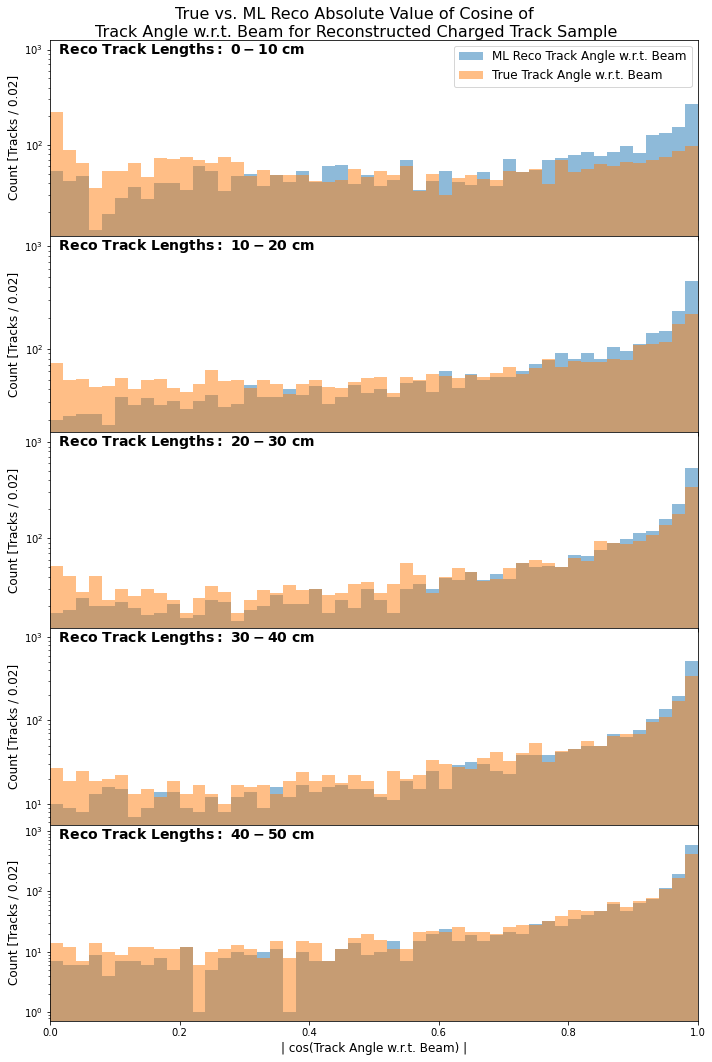

In [5]:
# CUT: Remove length bins with fewer than 5 tracks
ovlp_cut = 0.5
df_filtered = df[df['overlap']>=ovlp_cut]
sample = 'reco_charged_tracks_'
grouped_length = df_filtered.groupby('reco_length_bin')
stop_length_bin = 5
height = (stop_length_bin/num_length_bins)*45

fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])
max_count = 50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. Beam')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='True Track Angle w.r.t. Beam')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_xlabel('| cos(Track Angle w.r.t. Beam) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    #axs[i].legend(loc='upper right')
    axs[i].set_xlim(0, 1)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None,max_count+1000)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of \nTrack Angle w.r.t. Beam for Reconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_angle_wrt_beam_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

330.0


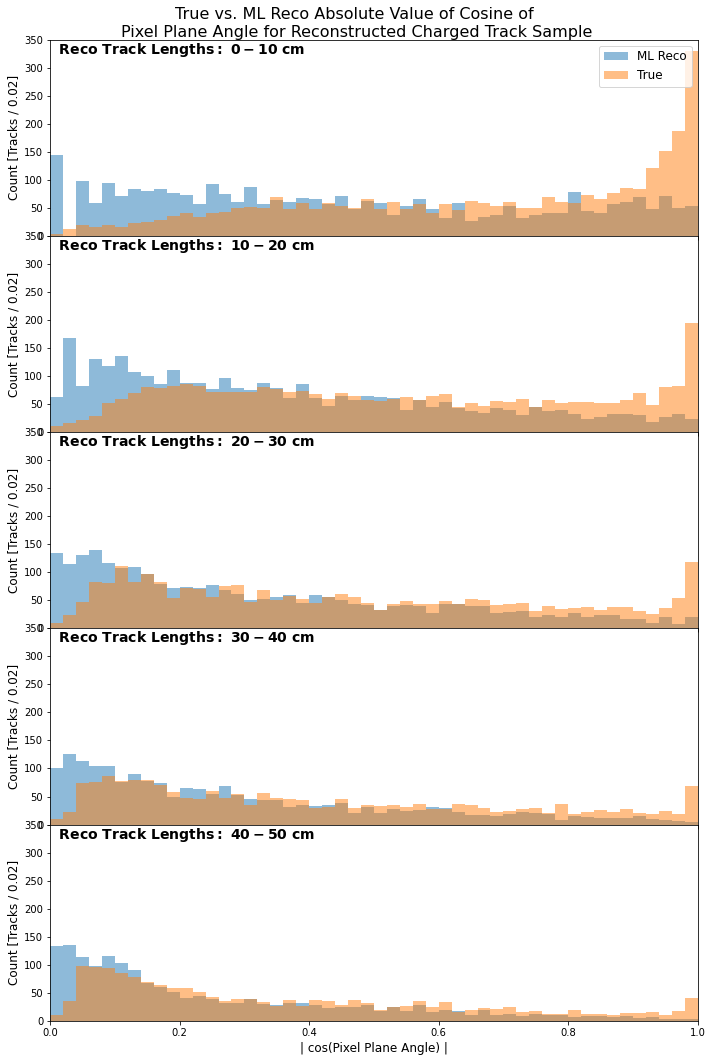

In [6]:
grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_rot'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_rot'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='True')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_xlabel('| cos(Pixel Plane Angle) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    #axs[i].legend(loc='upper right')
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, max_count+20)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of \nPixel Plane Angle for Reconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_rot_angle_wrt_anode_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

802.0


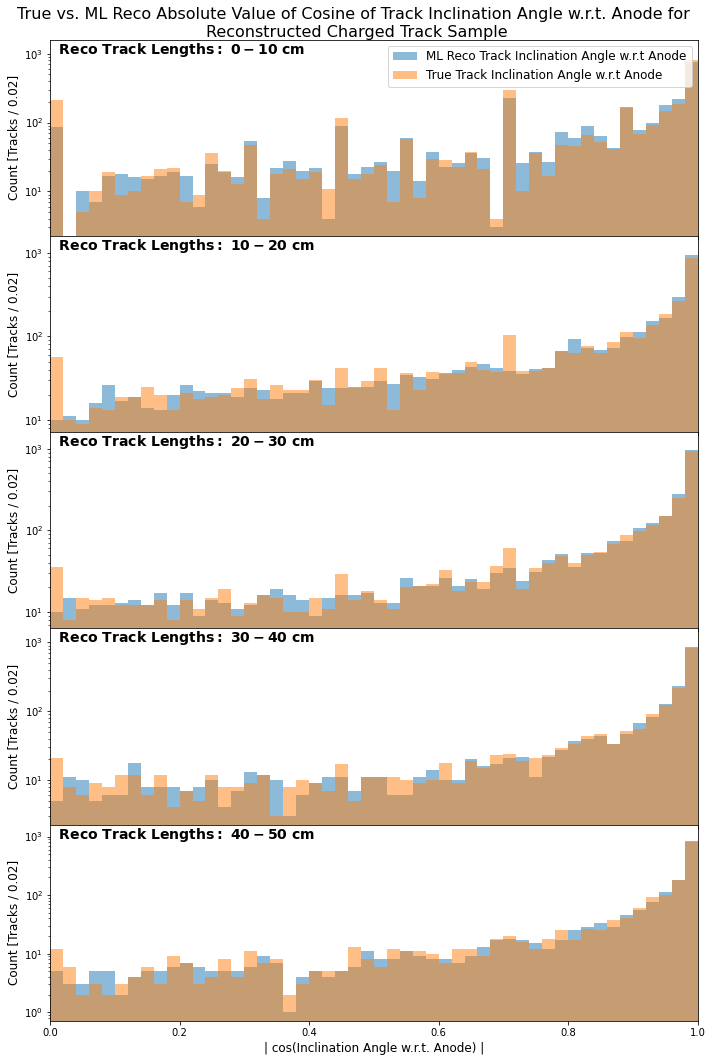

In [7]:
grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_incl'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Inclination Angle w.r.t Anode')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_incl'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Inclination Angle w.r.t Anode')
    axs[i].set_xlabel('| cos(Inclination Angle w.r.t. Anode) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Inclination Angle w.r.t. Anode for \nReconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_incl_angle_wrt_anode_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

In [8]:
# Check track direction by looking at unit vectors
df_filtered['reco_x_dir'] = df_filtered['reco_track_end_x'] - df_filtered['reco_track_start_x']
df_filtered['reco_y_dir'] = df_filtered['reco_track_end_y'] - df_filtered['reco_track_start_y']
df_filtered['reco_z_dir'] = df_filtered['reco_track_end_z'] - df_filtered['reco_track_start_z']
df_filtered['true_x_dir'] = df_filtered['true_track_end_x'] - df_filtered['true_track_start_x']
df_filtered['true_y_dir'] = df_filtered['true_track_end_y'] - df_filtered['true_track_start_y']
df_filtered['true_z_dir'] = df_filtered['true_track_end_z'] - df_filtered['true_track_start_z']

df_filtered['reco_x_unit_dir'] = df_filtered['reco_x_dir']/np.sqrt(df_filtered['reco_x_dir']**2 + df_filtered['reco_y_dir']**2 + df_filtered['reco_z_dir']**2)
df_filtered['reco_y_unit_dir'] = df_filtered['reco_y_dir']/np.sqrt(df_filtered['reco_x_dir']**2 + df_filtered['reco_y_dir']**2 + df_filtered['reco_z_dir']**2)
df_filtered['reco_z_unit_dir'] = df_filtered['reco_z_dir']/np.sqrt(df_filtered['reco_x_dir']**2 + df_filtered['reco_y_dir']**2 + df_filtered['reco_z_dir']**2)
df_filtered['true_x_unit_dir'] = df_filtered['true_x_dir']/np.sqrt(df_filtered['true_x_dir']**2 + df_filtered['true_y_dir']**2 + df_filtered['true_z_dir']**2)
df_filtered['true_y_unit_dir'] = df_filtered['true_y_dir']/np.sqrt(df_filtered['true_x_dir']**2 + df_filtered['true_y_dir']**2 + df_filtered['true_z_dir']**2)
df_filtered['true_z_unit_dir'] = df_filtered['true_z_dir']/np.sqrt(df_filtered['true_x_dir']**2 + df_filtered['true_y_dir']**2 + df_filtered['true_z_dir']**2)


/tmp/ipykernel_5351/2218900340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['reco_x_dir'] = df_filtered['reco_track_end_x'] - df_filtered['reco_track_start_x']
/tmp/ipykernel_5351/2218900340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['reco_y_dir'] = df_filtered['reco_track_end_y'] - df_filtered['reco_track_start_y']
/tmp/ipykernel_5351/2218900340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

159.0


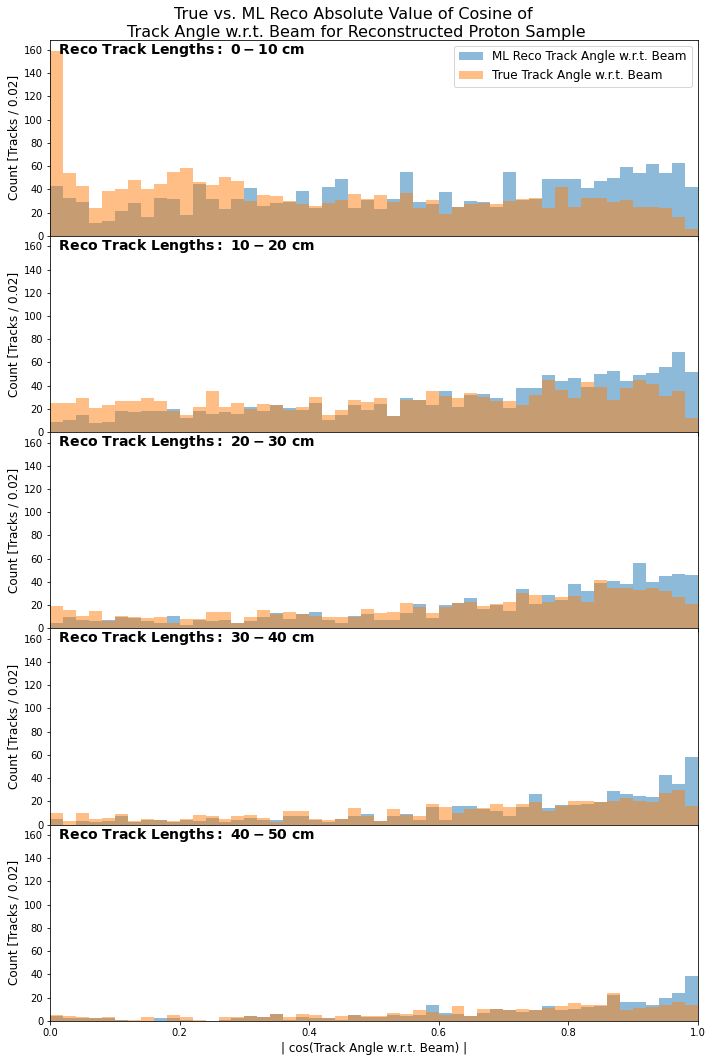

In [9]:
# PROTONS ONLY 
sample = 'reco_protons_'
df_protons = df_filtered[df_filtered['true_pdg'] == 2212]
grouped_length = df_protons.groupby('reco_length_bin')

fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])
max_count = 50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. Beam')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='True Track Angle w.r.t. Beam')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_xlabel('| cos(Track Angle w.r.t. Beam) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    #axs[i].legend(loc='upper right')
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, max_count+10)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of \nTrack Angle w.r.t. Beam for Reconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_wrt_beam_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

226.0


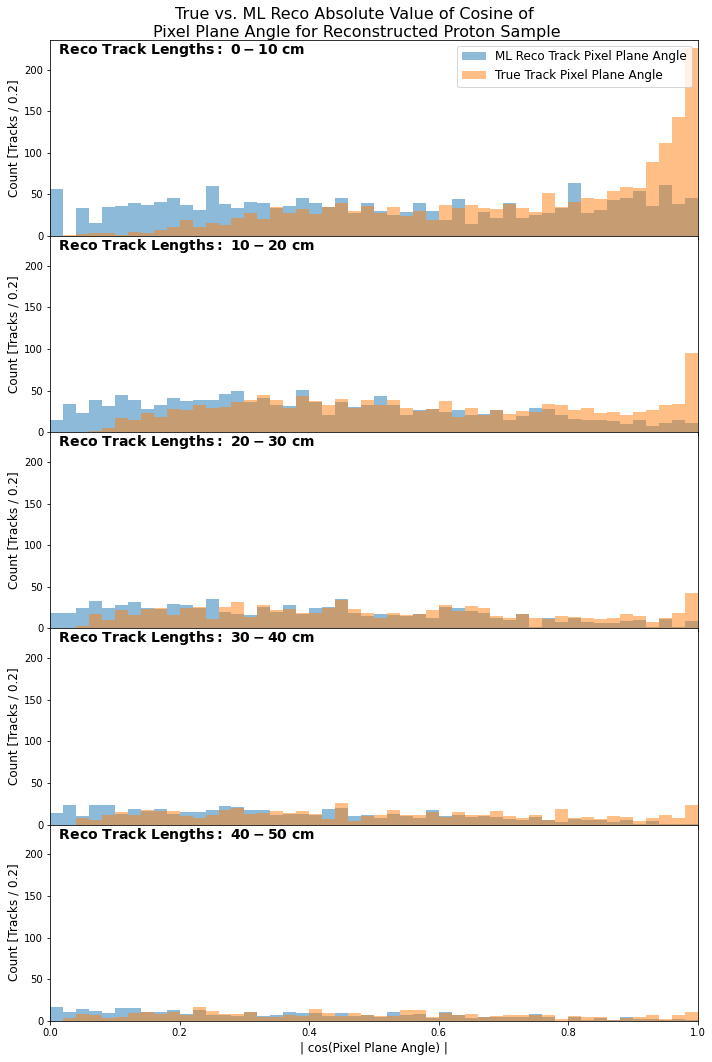

In [10]:
grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])
max_count = 50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_rot'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Pixel Plane Angle')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_rot'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='True Track Pixel Plane Angle')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_xlabel('| cos(Pixel Plane Angle) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.2]', fontsize=12)
    #axs[i].legend(loc='upper right')
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, max_count+10)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of \nPixel Plane Angle for Reconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_rot_angle_wrt_anode_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

387.0


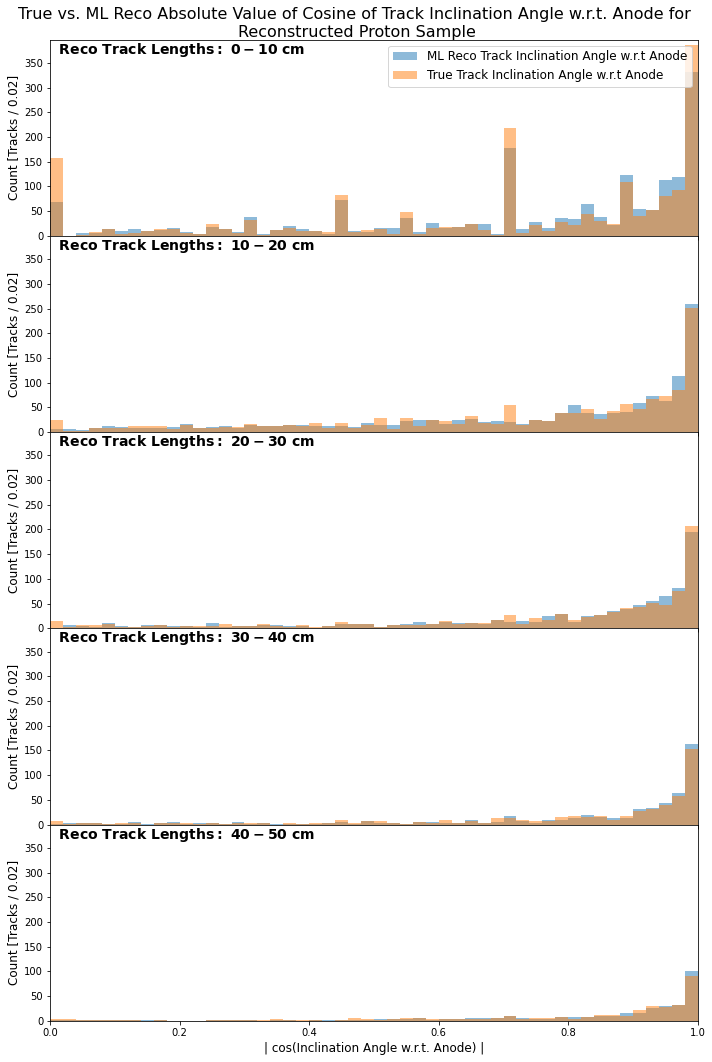

In [11]:
grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_incl'])), alpha=0.5, bins=50, range=(0,1), histtype='stepfilled', label='ML Reco Track Inclination Angle w.r.t Anode')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_incl'])), alpha=0.5, bins=50, range=(0,1),histtype='stepfilled', label='True Track Inclination Angle w.r.t Anode')
    axs[i].set_xlabel('| cos(Inclination Angle w.r.t. Anode) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0, 1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_ylim(0, max_count+10.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Inclination Angle w.r.t. Anode for \nReconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_incl_angle_wrt_anode_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

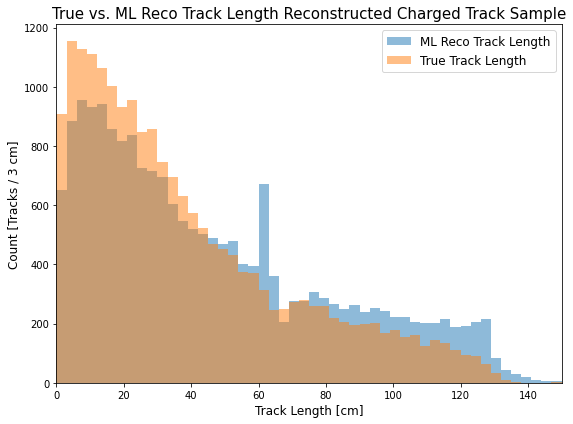

In [12]:
# Charged Track Lengths

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_filtered['reco_length'], alpha=0.5, bins=50, range=(0, 150), histtype='stepfilled', label='ML Reco Track Length')
true_counts, true_bins, _ = axs.hist(df_filtered['true_length'], alpha=0.5, bins=50, range=(0, 150),histtype='stepfilled', label='True Track Length')
axs.set_xlabel('Track Length [cm]', fontsize=12)
axs.set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs.set_xlim(0, 150)


axs.legend(loc='upper right', fontsize=12)
axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
#fig.suptitle('True vs. ML Reco Track Start Position for Reconstructed Charge Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()


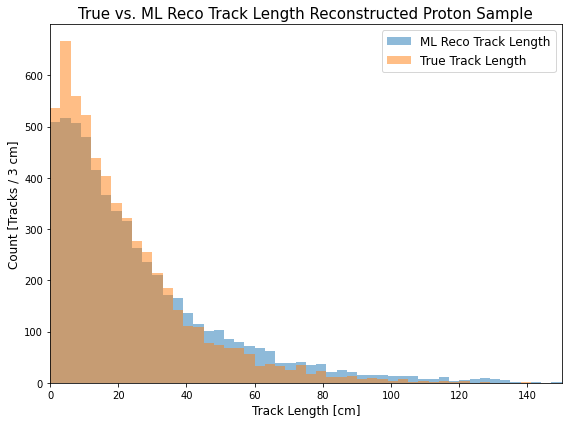

In [13]:
# Proton Track Lengths

sample = 'reco_protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_protons['reco_length'], alpha=0.5, bins=50, range=(0, 150), histtype='stepfilled', label='ML Reco Track Length')
true_counts, true_bins, _ = axs.hist(df_protons['true_length'], alpha=0.5, bins=50, range=(0, 150),histtype='stepfilled', label='True Track Length')
axs.set_xlabel('Track Length [cm]', fontsize=12)
axs.set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs.set_xlim(0, 150)


axs.legend(loc='upper right', fontsize=12)
axs.set_title('True vs. ML Reco Track Length Reconstructed Proton Sample', fontsize=15)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

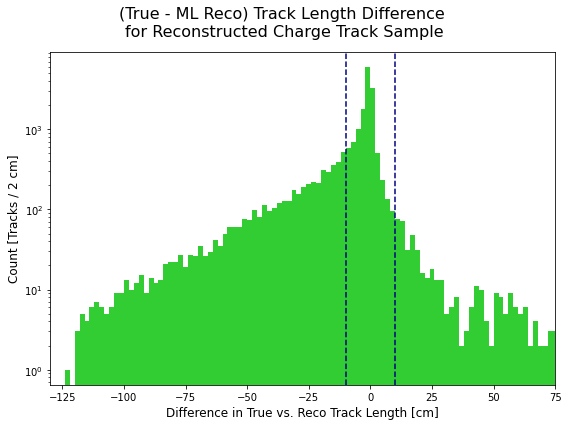

In [14]:
# Charged Track Lengths Difference

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist(df_filtered['true_length']-df_filtered['reco_length'], alpha=1.0, bins=150, range=(-150, 150),\
                                      histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. Reco Track Length [cm]', fontsize=12)
axs.set_ylabel('Count [Tracks / 2 cm]', fontsize=12)
axs.set_xlim(-130, 75)
axs.set_yscale('log')
plt.axvline(x=10, color='navy', linestyle='--')  # Draw a red dashed line at x=10
plt.axvline(x=-10, color='navy', linestyle='--')  # Draw a red dashed line at x=-10


#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Track Length Difference \nfor Reconstructed Charge Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

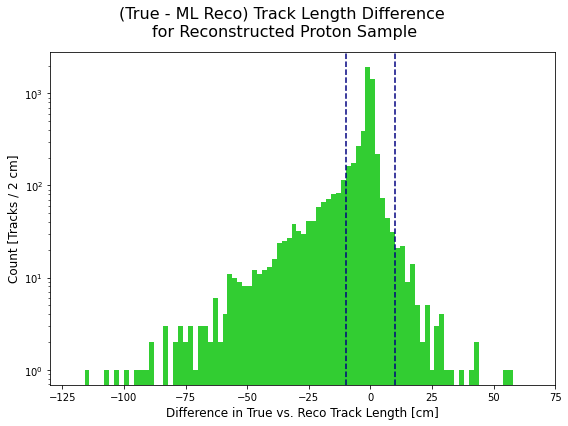

In [15]:
# Proton Track Lengths Difference

grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist(df_protons['true_length']-df_protons['reco_length'], alpha=1.0, bins=150, range=(-150, 150),\
                                      histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. Reco Track Length [cm]', fontsize=12)
axs.set_ylabel('Count [Tracks / 2 cm]', fontsize=12)
axs.set_xlim(-130, 75)
axs.set_yscale('log')
plt.axvline(x=10, color='navy', linestyle='--')  # Draw a red dashed line at x=10
plt.axvline(x=-10, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Track Length Difference \nfor Reconstructed Proton Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

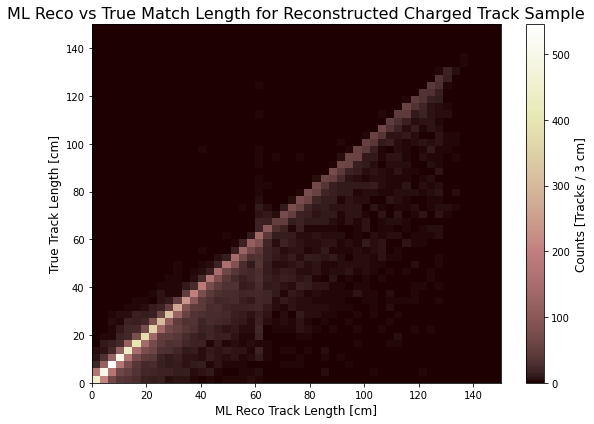

In [16]:
# Charged Track Lengths 2D Hist

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'

fig, ax = plt.subplots(figsize=[8,6])

counts, xedges, yedges, im = ax.hist2d(df_filtered['reco_length'], df_filtered['true_length'], bins=50, range=[[0, 150], [0, 150]], cmap='pink')

ax.set_xlabel('ML Reco Track Length [cm]', fontsize=12)
ax.set_ylabel('True Track Length [cm]', fontsize=12)
ax.set_title('ML Reco vs True Match Length for Reconstructed Charged Track Sample', fontsize=16)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Counts [Tracks / 3 cm]', fontsize=12)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_2d_hist_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

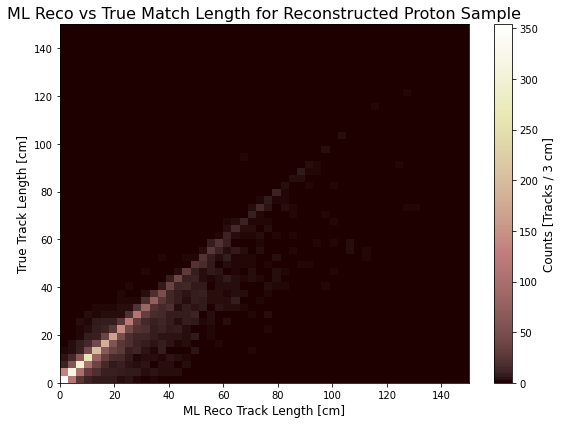

In [17]:
#Proton Track Lengths 2D Hist
grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'

fig, ax = plt.subplots(figsize=[8,6])

counts, xedges, yedges, im = ax.hist2d(df_protons['reco_length'], df_protons['true_length'], bins=50, range=[[0, 150], [0, 150]], cmap='pink')

ax.set_xlabel('ML Reco Track Length [cm]', fontsize=12)
ax.set_ylabel('True Track Length [cm]', fontsize=12)
ax.set_title('ML Reco vs True Match Length for Reconstructed Proton Sample', fontsize=16)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Counts [Tracks / 3 cm]', fontsize=12)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_length_2d_hist_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

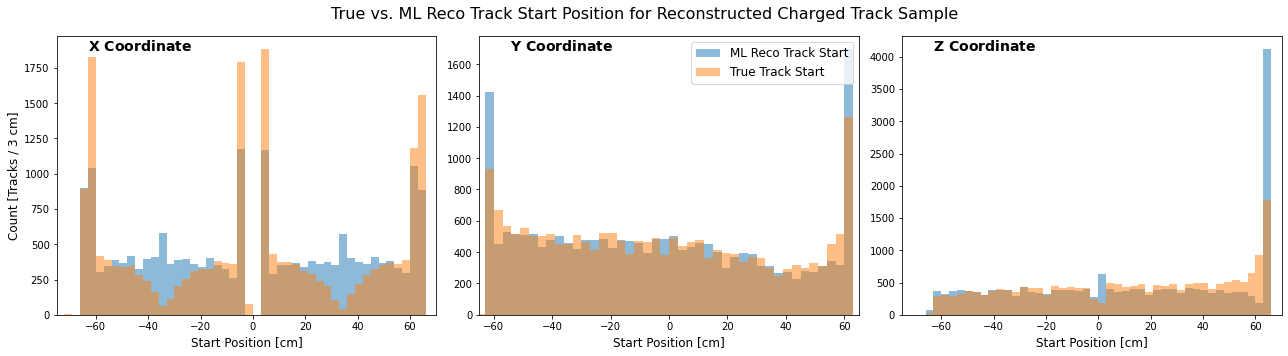

In [18]:
# Charged Track Start XYZ

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(1,3, figsize=[18, 5])


reco_countsx, reco_binsx, _x = axs[0].hist(df_filtered['reco_track_start_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsx, true_binsx, _x = axs[0].hist(df_filtered['true_track_start_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[0].set_xlabel('Start Position [cm]', fontsize=12)
axs[0].set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs[0].set_xlim(-75, 70)

reco_countsy, reco_binsy, _y = axs[1].hist(df_filtered['reco_track_start_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsy, true_binsy, _y = axs[1].hist(df_filtered['true_track_start_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[1].set_xlabel('Start Position [cm]', fontsize=12)
axs[1].set_xlim(-65, 65)

reco_countsz, reco_binsz, _z = axs[2].hist(df_filtered['reco_track_start_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsz, true_binsz, _z = axs[2].hist(df_filtered['true_track_start_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[2].set_xlabel('Start Position [cm]', fontsize=12)
axs[2].set_xlim(-75, 70)

axs[1].legend(loc='upper right', fontsize=12)
axs[0].set_title('       '+r'$\bf{X\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[1].set_title('       '+r'$\bf{Y\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[2].set_title('       '+r'$\bf{Z\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Track Start Position for Reconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_start_position_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

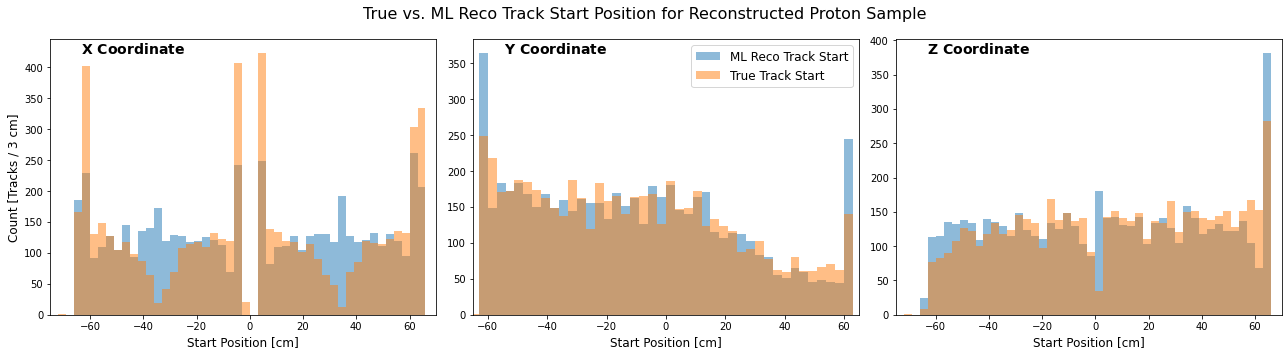

In [19]:
# Charged Track Start XYZ

grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(1,3, figsize=[18, 5])


reco_countsx, reco_binsx, _x = axs[0].hist(df_protons['reco_track_start_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsx, true_binsx, _x = axs[0].hist(df_protons['true_track_start_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[0].set_xlabel('Start Position [cm]', fontsize=12)
axs[0].set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs[0].set_xlim(-75, 70)

reco_countsy, reco_binsy, _y = axs[1].hist(df_protons['reco_track_start_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsy, true_binsy, _y = axs[1].hist(df_protons['true_track_start_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[1].set_xlabel('Start Position [cm]', fontsize=12)
axs[1].set_xlim(-65, 65)

reco_countsz, reco_binsz, _z = axs[2].hist(df_protons['reco_track_start_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track Start')
true_countsz, true_binsz, _z = axs[2].hist(df_protons['true_track_start_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track Start')
axs[2].set_xlabel('Start Position [cm]', fontsize=12)
axs[2].set_xlim(-75, 70)

axs[1].legend(loc='upper right', fontsize=12)
axs[0].set_title('       '+r'$\bf{X\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[1].set_title('       '+r'$\bf{Y\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[2].set_title('       '+r'$\bf{Z\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Track Start Position for Reconstructed Proton Sample', fontsize=16)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_start_position_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

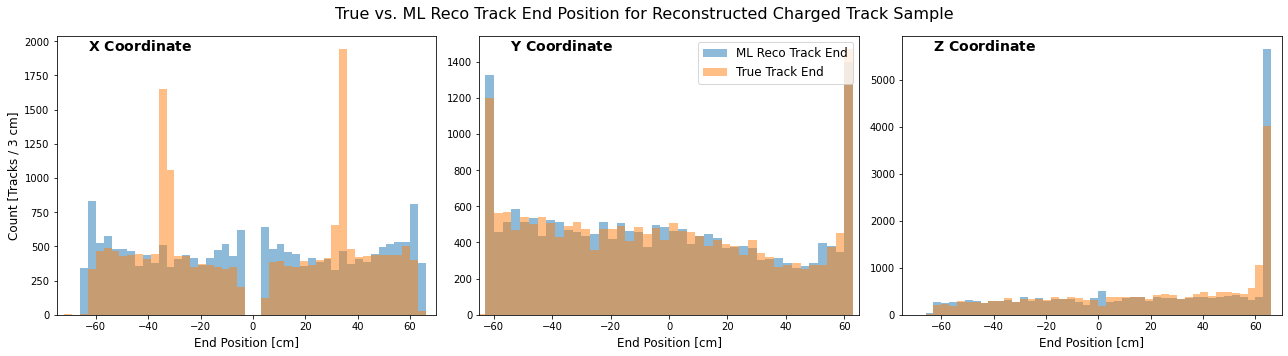

In [20]:
# Charged Track End XYZ

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(1,3, figsize=[18, 5])


reco_countsx, reco_binsx, _x = axs[0].hist(df_filtered['reco_track_end_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsx, true_binsx, _x = axs[0].hist(df_filtered['true_track_end_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[0].set_xlabel('End Position [cm]', fontsize=12)
axs[0].set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs[0].set_xlim(-75, 70)

reco_countsy, reco_binsy, _y = axs[1].hist(df_filtered['reco_track_end_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsy, true_binsy, _y = axs[1].hist(df_filtered['true_track_end_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[1].set_xlabel('End Position [cm]', fontsize=12)
axs[1].set_xlim(-65, 65)

reco_countsz, reco_binsz, _z = axs[2].hist(df_filtered['reco_track_end_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsz, true_binsz, _z = axs[2].hist(df_filtered['true_track_end_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[2].set_xlabel('End Position [cm]', fontsize=12)
axs[2].set_xlim(-75, 70)

axs[1].legend(loc='upper right', fontsize=12)
axs[0].set_title('       '+r'$\bf{X\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[1].set_title('       '+r'$\bf{Y\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[2].set_title('       '+r'$\bf{Z\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Track End Position for Reconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_end_position_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

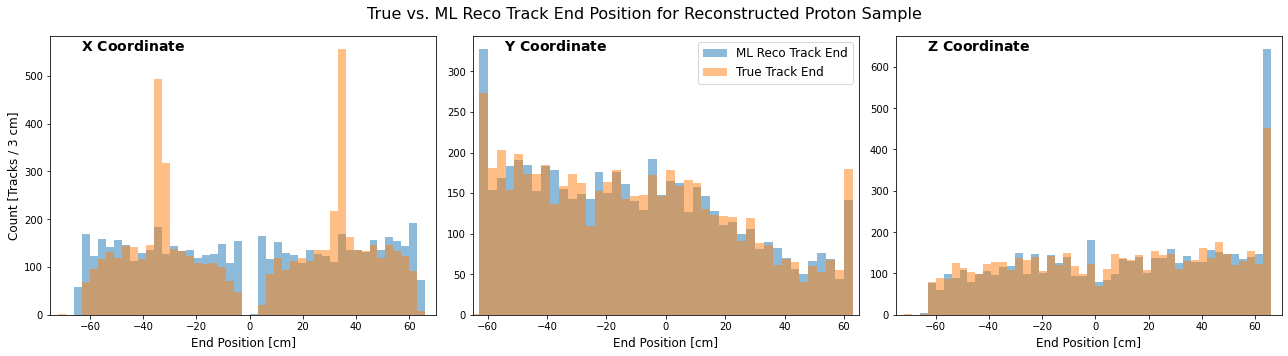

In [21]:
# Charged Track End XYZ

grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(1,3, figsize=[18, 5])


reco_countsx, reco_binsx, _x = axs[0].hist(df_protons['reco_track_end_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsx, true_binsx, _x = axs[0].hist(df_protons['true_track_end_x'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[0].set_xlabel('End Position [cm]', fontsize=12)
axs[0].set_ylabel('Count [Tracks / 3 cm]', fontsize=12)
axs[0].set_xlim(-75, 70)

reco_countsy, reco_binsy, _y = axs[1].hist(df_protons['reco_track_end_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsy, true_binsy, _y = axs[1].hist(df_protons['true_track_end_y'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[1].set_xlabel('End Position [cm]', fontsize=12)
axs[1].set_xlim(-65, 65)

reco_countsz, reco_binsz, _z = axs[2].hist(df_protons['reco_track_end_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='ML Reco Track End')
true_countsz, true_binsz, _z = axs[2].hist(df_protons['true_track_end_z'], alpha=0.5, bins=100, range=(-150, 150), histtype='stepfilled', label='True Track End')
axs[2].set_xlabel('End Position [cm]', fontsize=12)
axs[2].set_xlim(-75, 70)

axs[1].legend(loc='upper right', fontsize=12)
axs[0].set_title('       '+r'$\bf{X\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[1].set_title('       '+r'$\bf{Y\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
axs[2].set_title('       '+r'$\bf{Z\ Coordinate}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Track End Position for Reconstructed Proton Sample', fontsize=16)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_end_position_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

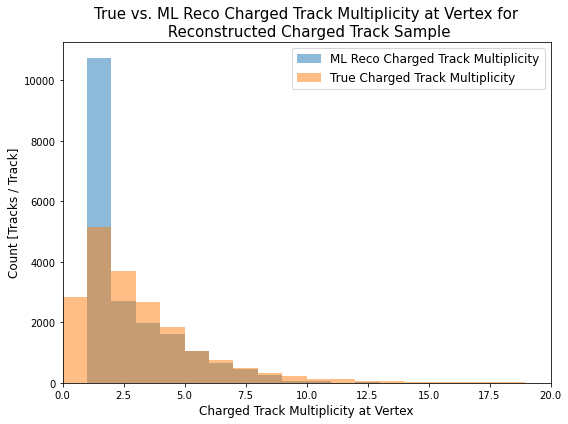

In [22]:
# Charged Track Mult at vertex

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_filtered['reco_ixn_charged_track_mult'], alpha=0.5, bins=50, range=(0, 50), histtype='stepfilled', label='ML Reco Charged Track Multiplicity')
true_counts, true_bins, _ = axs.hist(df_filtered['true_ixn_charged_track_mult'], alpha=0.5, bins=50, range=(0, 50),histtype='stepfilled', label='True Charged Track Multiplicity')
axs.set_xlabel('Charged Track Multiplicity at Vertex', fontsize=12)
axs.set_ylabel('Count [Tracks / Track]', fontsize=12)
axs.set_xlim(0, 20)


axs.legend(loc='upper right', fontsize=12)
axs.set_title('True vs. ML Reco Charged Track Multiplicity at Vertex for\n Reconstructed Charged Track Sample', fontsize=15)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_charged_track_mult_at_vertex_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

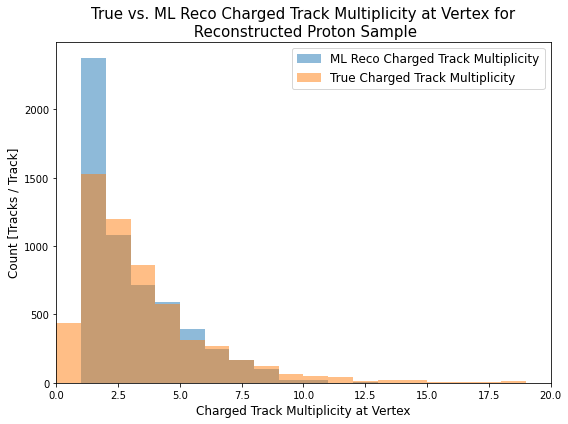

In [23]:
# Proton Track Mult at vertex

sample = 'reco_protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


reco_counts, reco_bins, _ = axs.hist(df_protons['reco_ixn_charged_track_mult'], alpha=0.5, bins=50, range=(0, 50), histtype='stepfilled', label='ML Reco Charged Track Multiplicity')
true_counts, true_bins, _ = axs.hist(df_protons['true_ixn_charged_track_mult'], alpha=0.5, bins=50, range=(0, 50),histtype='stepfilled', label='True Charged Track Multiplicity')
axs.set_xlabel('Charged Track Multiplicity at Vertex', fontsize=12)
axs.set_ylabel('Count [Tracks / Track]', fontsize=12)
axs.set_xlim(0, 20)


axs.legend(loc='upper right', fontsize=12)
axs.set_title('True vs. ML Reco Charged Track Multiplicity at Vertex for\n Reconstructed Proton Sample', fontsize=15)

plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_charged_track_mult_at_vertex_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

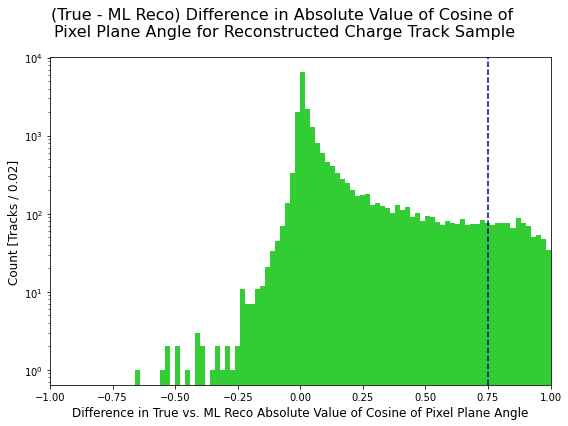

In [24]:
# Charged Track absolute cosine of angle rot difference

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_filtered['true_angle_rot']))-abs(np.cos(df_filtered['reco_angle_rot']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Pixel Plane Angle', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=0.75, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nPixel Plane Angle for Reconstructed Charge Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_rot_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

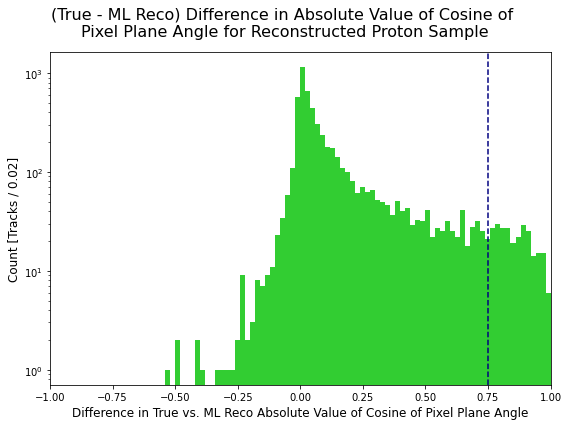

In [25]:
# Proton absolute cosine of angle rot difference

sample = 'reco_protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_protons['true_angle_rot']))-abs(np.cos(df_protons['reco_angle_rot']))), alpha=1.0, \
                                     bins=100, range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Pixel Plane Angle', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=0.75, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nPixel Plane Angle for Reconstructed Proton Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_rot_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

In [26]:
print("Length of Charged Track Sample: ", len(df_filtered))
print("Length of Proton Sample: ", len(df_protons))


Length of Charged Track Sample:  19594
Length of Proton Sample:  5726


330.0


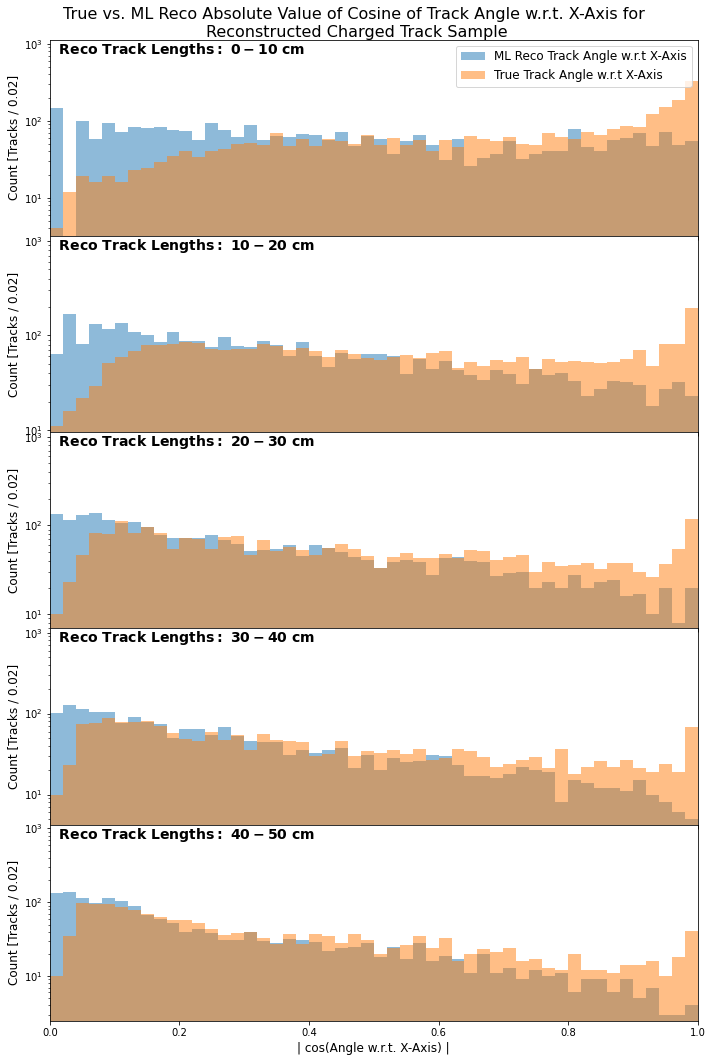

In [27]:
grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_x'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. X-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_x'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t. X-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. X-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. X-Axis for \nReconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_x_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

226.0


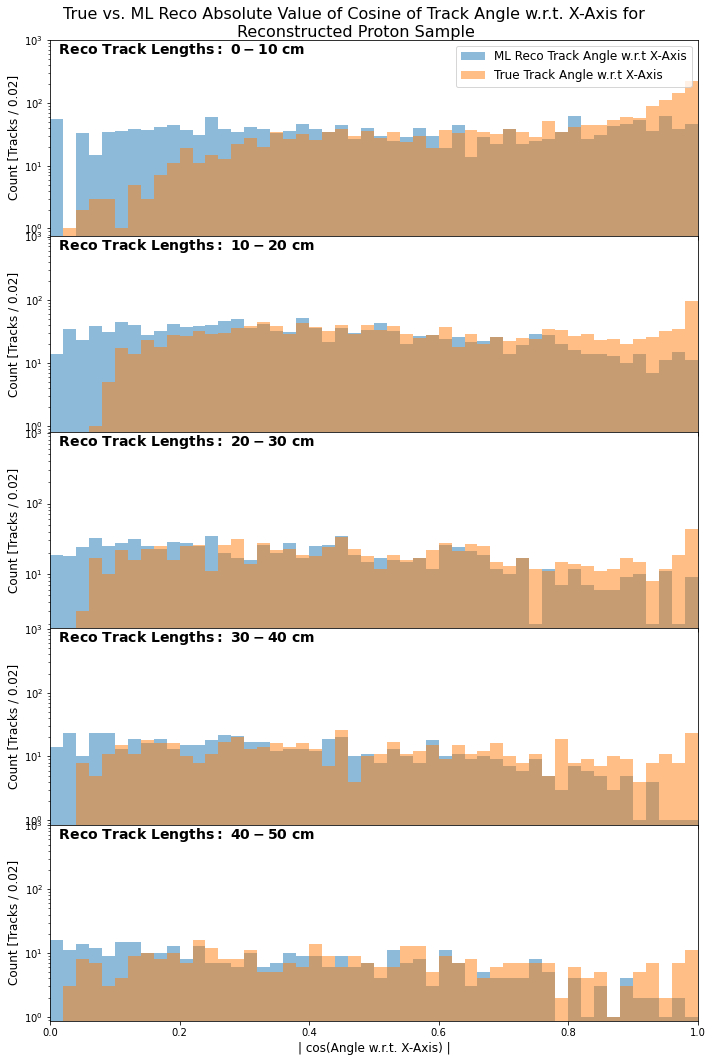

In [28]:
grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_x'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. X-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_x'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t. X-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. X-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. X-Axis for \nReconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_x_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

414.0


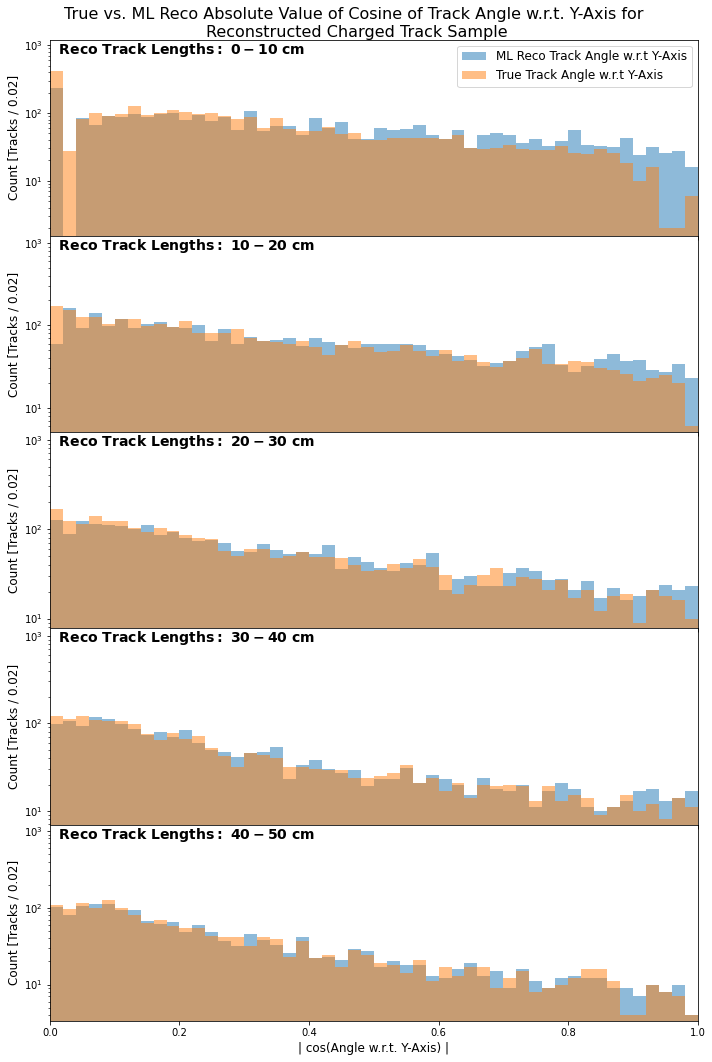

In [29]:
grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_y'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. Y-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_y'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t. Y-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. Y-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Y-Axis for \nReconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_y_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

242.0


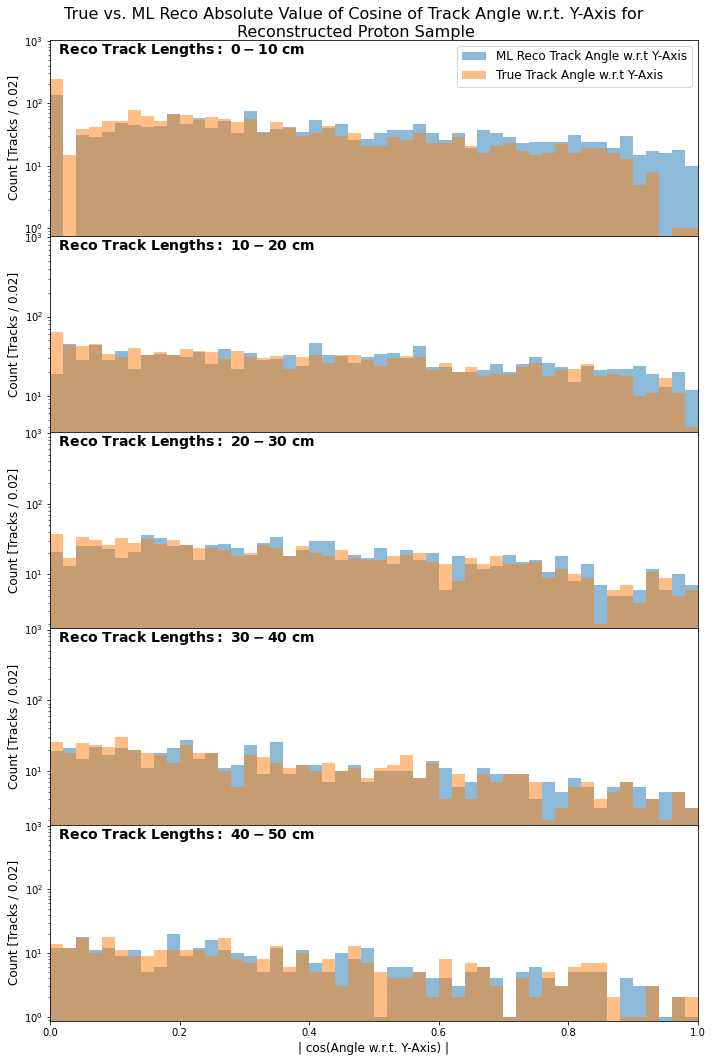

In [30]:
grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_y'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. Y-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_y'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t. Y-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. Y-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Y-Axis for \nReconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_y_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

287.0


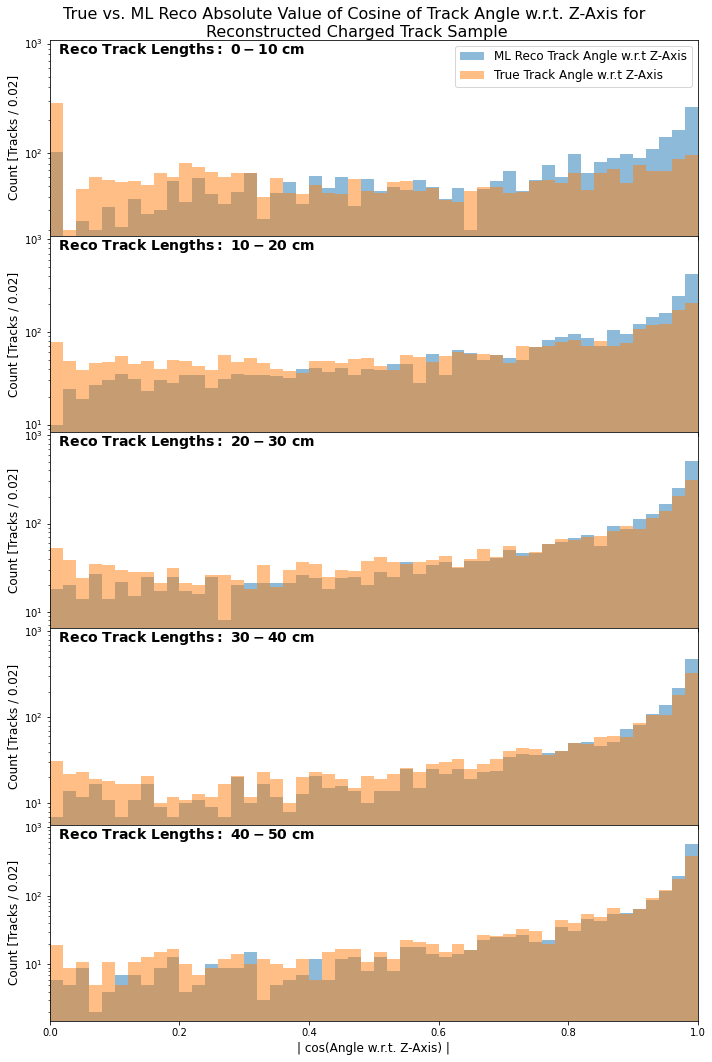

In [31]:
grouped_length = df_filtered.groupby('reco_length_bin')
sample = 'reco_charged_tracks_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_z'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t. Z-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_z'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t. Z-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. Z-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Z-Axis for \nReconstructed Charged Track Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_z_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

211.0


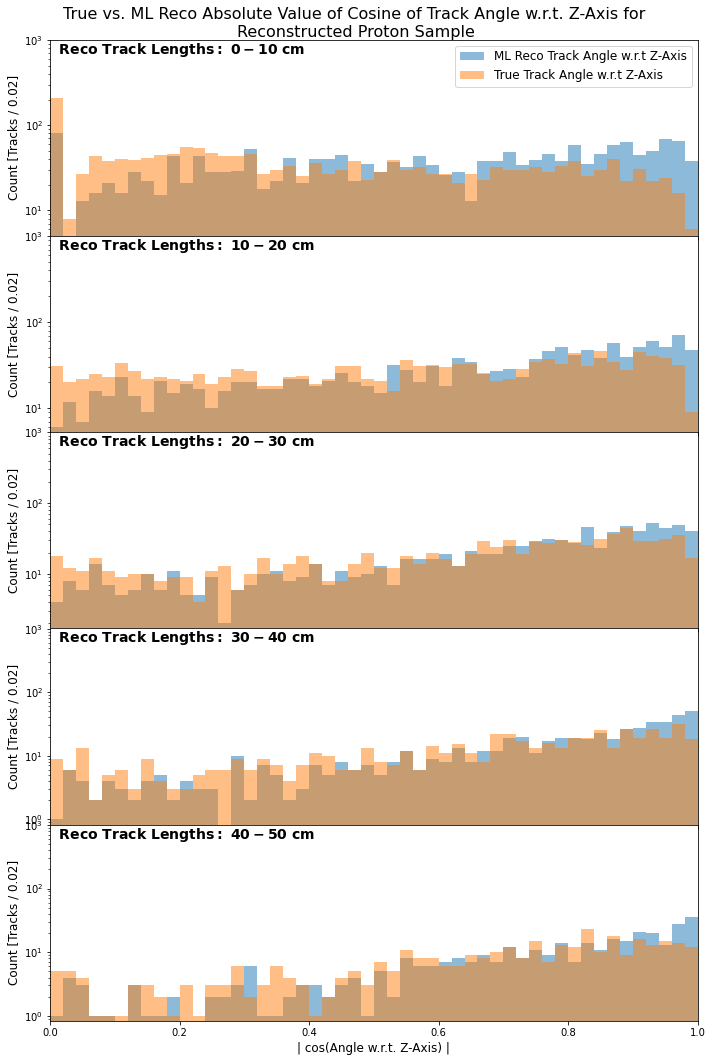

In [32]:
grouped_length = df_protons.groupby('reco_length_bin')
sample = 'reco_protons_'
fig, axs = plt.subplots(stop_length_bin, sharex=True, figsize=[10, height])

max_count=50.
for i, (name, group) in enumerate(grouped_length):
    if i>=stop_length_bin:
        break
    reco_counts, reco_bins, _ = axs[i].hist(abs(np.cos(group['reco_angle_z'])), alpha=0.5, bins=50, range=(0, 1), histtype='stepfilled', label='ML Reco Track Angle w.r.t Z-Axis')
    true_counts, true_bins, _ = axs[i].hist(abs(np.cos(group['true_angle_z'])), alpha=0.5, bins=50, range=(0, 1),histtype='stepfilled', label='True Track Angle w.r.t Z-Axis')
    axs[i].set_xlabel('| cos(Angle w.r.t. Z-Axis) |', fontsize=12)
    axs[i].set_ylabel('Count [Tracks / 0.02]', fontsize=12)
    axs[i].set_xlim(0,1)
    #axs[i].legend(loc='upper right')
    if i==0:
        max_count = np.max(np.array([np.max(reco_counts), np.max(true_counts)]))
        print(max_count)
        axs[i].legend(loc='upper right', fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(None, max_count+800.)
    length_min = max_length/num_length_bins*(name-1)
    length_max = max_length/num_length_bins*name
    axs[i].set_title('  '+rf'$\bf{{Reco\ Track\ Lengths:\ {length_min:.0f} - {length_max:.0f}\ cm}}$', y=1.0, loc='left', pad=-14, fontsize=14)
fig.suptitle('True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Z-Axis for \nReconstructed Proton Sample', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_of_angle_w_z_axis_by_length_bin_with_ovlp_cut_'+str(ovlp_cut)+'_up_to_length_bin_'+str(stop_length_bin)+'.pdf')
#plt.show()

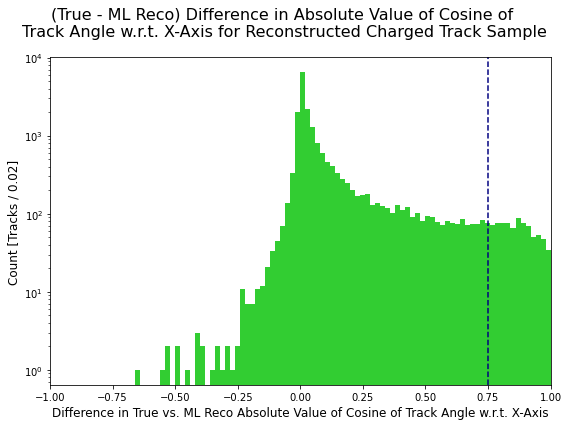

In [33]:

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_filtered['true_angle_x']))-abs(np.cos(df_filtered['reco_angle_x']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. X-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=0.75, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. X-Axis for Reconstructed Charged Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_x_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

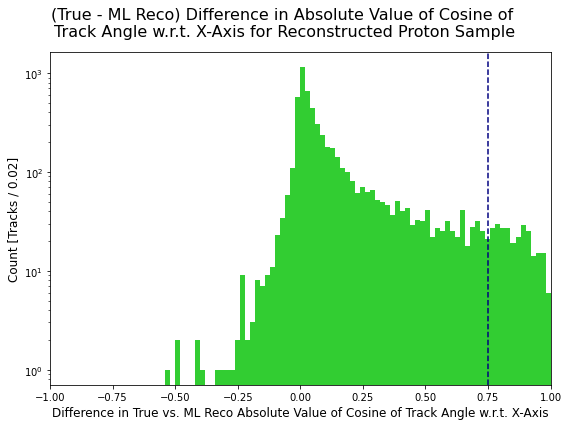

In [34]:
sample = 'protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_protons['true_angle_x']))-abs(np.cos(df_protons['reco_angle_x']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. X-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=0.75, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. X-Axis for Reconstructed Proton Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_x_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

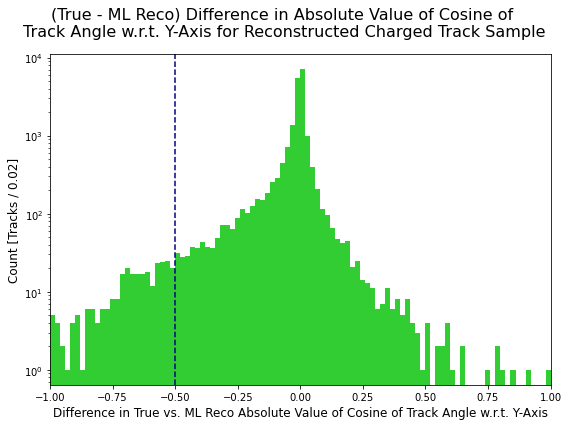

In [37]:

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_filtered['true_angle_y']))-abs(np.cos(df_filtered['reco_angle_y']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Y-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=-0.5, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. Y-Axis for Reconstructed Charged Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_y_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

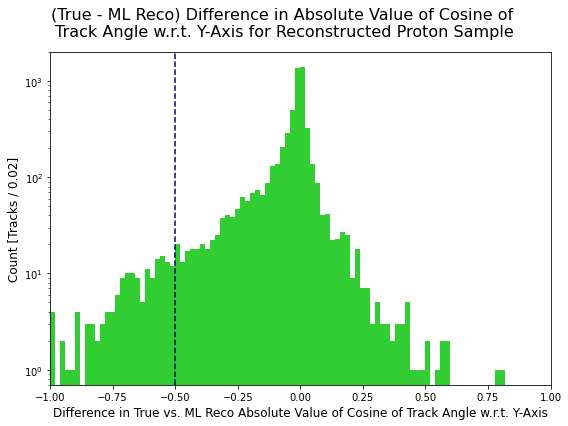

In [38]:
sample = 'protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_protons['true_angle_y']))-abs(np.cos(df_protons['reco_angle_y']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Y-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=-0.5, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. Y-Axis for Reconstructed Proton Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_y_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

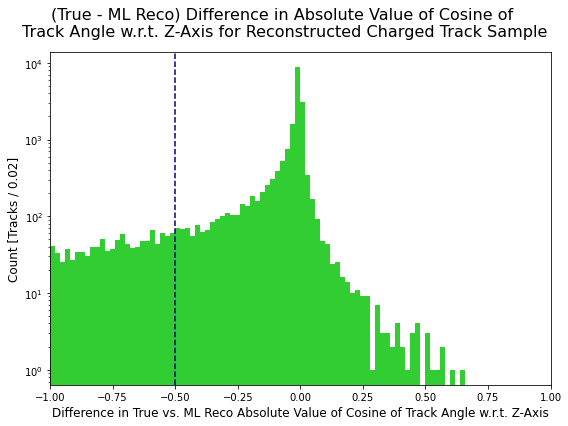

In [39]:

sample = 'reco_charged_tracks_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_filtered['true_angle_z']))-abs(np.cos(df_filtered['reco_angle_z']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Z-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=-0.5, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. Z-Axis for Reconstructed Charged Track Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_z_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()

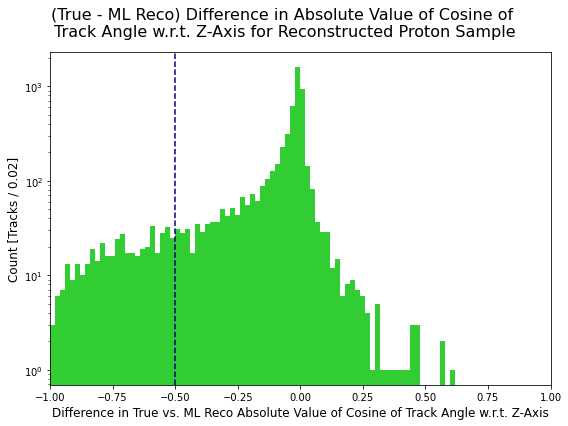

In [40]:
sample = 'protons_'
fig = plt.figure(figsize=[8,6])
axs = fig.add_subplot(111)


diff_counts, diff_bins, _ = axs.hist((abs(np.cos(df_protons['true_angle_z']))-abs(np.cos(df_protons['reco_angle_z']))), alpha=1.0, bins=100, \
                                     range=(-1, 1), histtype='stepfilled', color='limegreen')
axs.set_xlabel('Difference in True vs. ML Reco Absolute Value of Cosine of Track Angle w.r.t. Z-Axis', fontsize=12)
axs.set_ylabel('Count [Tracks / 0.02]', fontsize=12)
axs.set_xlim(-1,1)
axs.set_yscale('log')
plt.axvline(x=-0.5, color='navy', linestyle='--')  # Draw a red dashed line at x=-10



#axs.legend(loc='upper right', fontsize=12)
#axs.set_title('True vs. ML Reco Track Length Reconstructed Charged Track Sample', fontsize=15)
fig.suptitle('(True - ML Reco) Difference in Absolute Value of Cosine of \nTrack Angle w.r.t. Z-Axis for Reconstructed Proton Sample', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.95, hspace=0.0)
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/'+sample+'true_vs_reco_abs_cos_z_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.pdf')
#plt.show()